In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  1 23:05:50 2020

@author: kosed
"""
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from os.path import dirname, join as pjoin
import warnings
import torch
import PIL
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sn
from sklearn.metrics import multilabel_confusion_matrix
from torch.autograd import Variable
warnings.filterwarnings('ignore')
import cv2
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive

drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def report_performance(predictions, labels):
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    
        
    if type(predictions).__module__ == torch.__name__ :
        predictions = predictions.tolist()
    if type(labels).__module__ == torch.__name__ :
        labels = labels.tolist()
    
    if type(predictions).__module__ == np.__name__ :
        predictions = list(predictions)
    if type(labels).__module__ == np.__name__ :
        labels = list(labels)
    

    
    size = len(genres);
    i = 0;
    
    while i < 10:
        if i in predictions:        
            for j, x in enumerate(predictions):
                if x == i:
                   predictions[j] = genres[i + size - 10]
        if i in labels:
            for j, x in enumerate(labels):
                if x == i: 
                    labels[j] = genres[i + size - 10]
        else: 
            del genres[i + size - 10]
            size -= 1
        i+=1; 
          

    data = {'y_Actual':    labels,
            'y_Predicted': predictions
            }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
   
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    print(classification_report(labels, predictions))
    
    cnf = multilabel_confusion_matrix(labels, predictions)

    for i in range(0, len(genres)):
        if (cnf[i][0][1]+cnf[i][1][1]) != 0:
            print("Accuracy for", genres[i], "is:", cnf[i][1][1]/(cnf[i][0][1]+cnf[i][1][1]), "\n")

In [0]:
# %%  EXTRACT SOUND WAVES FROM SONGS

def extract_data():
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    data = []
    for g in genres:
        for filename in os.listdir(f'drive/My Drive/machine learning/rescaled400_daha_net/{g}'):
            songname = f'drive/My Drive/machine learning/rescaled400_daha_net/{g}/{filename}'
            temp = plt.imread(songname)[:,:,:3]
            data.append(temp)
    return data

def shuffle(data, classes):
    dataset = np.r_['1', data, classes]
    np.random.shuffle(dataset)
    n, m = np.shape(dataset)
    train_size = 700
    validation_size = 100
    test_size = 200
    train_data = dataset[:train_size].astype(dtype='float32')
    x_train_data = train_data[:,0:m-1]
    y_train_data = train_data[:,m-1]
    x_train_data = np.reshape(x_train_data, (train_size,-1,3))
    y_train_data = np.reshape(y_train_data, (train_size))
    train_data = []
    for i in range(train_size):
        train_data.append([x_train_data[i], y_train_data[i]])

    validation_data = dataset[train_size:train_size+validation_size].astype(dtype='float32')
    x_validation_data = validation_data[:,0:m-1]
    y_validation_data = validation_data[:,m-1]

    x_validation_data = np.reshape(x_validation_data, (validation_size,-1,3))
    y_validation_data = np.reshape(y_validation_data, (validation_size))
    
    validation_data = []
    for i in range(validation_size):
        validation_data.append([x_validation_data[i], y_validation_data[i]])
    
    
    test_data = dataset[800:].astype(dtype='float32')
    x_test_data = test_data[:,0:m-1]
    y_test_data = test_data[:,m-1]
    x_test_data = np.reshape(x_test_data, (test_size,-1,3))
    y_test_data = np.reshape(y_test_data, (test_size))
    test_data = []
    for i in range(test_size):
        test_data.append([x_test_data[i], y_test_data[i]])
    
    return train_data, validation_data, test_data

def construct_labels():
    labels = []
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    numeration = [0,1,2,3,4,5,6,7,8,9]
    for g in numeration:
        for i in range(100):
            labels.append(g)
    return np.reshape(labels,(1000,1))





In [0]:
# %% Main
data = extract_data()
data = np.reshape(data, (np.shape(data)[0],-1,3))
data = np.reshape(data, (np.shape(data)[0],-1))
label = construct_labels()
train_data, validation_data, test_data = shuffle(data, label)

In [0]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [0]:
# %% model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):

    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(3, 8, 4, 2)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.conv2 = nn.Conv1d(8, 16, 32, 2)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv3 = nn.Conv1d(16, 64, 16)
        torch.nn.init.xavier_normal(self.conv3.weight)
        self.ap = nn.AvgPool1d(4)
        self.mp = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(39680,100)        
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.ap(self.conv1(x)))
        x = F.relu(self.ap(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)


def train(epoch, batchsize):
    
    model.train()
    total_loss = 0
    train_acc = 0
    c = 0;
    for batch_idx, data in enumerate(train_loader):
        c += 1
        label = data[1]
        label = label.to(dtype=torch.int64)
        data = data[0]
        data = np.reshape(data,(batch_size, 3, -1))
        data, target = Variable(data), Variable(label)
        optimizer.zero_grad()
        
        output = model(data.to(device))
        
        loss = F.nll_loss(output.to(device), target.to(device))
        total_loss += loss.detach().item()
        loss.backward()
        optimizer.step()

        train_acc += get_accuracy(output.to('cpu'), target, batch_size)

        if( batch_idx % 2 == 0 ):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item(), (train_acc/c)))
    return total_loss / batch_idx, train_acc/c
def validate():
    correct = 0
    total = 0
    

    for data in (validation_loader):
      
        label = data[1]
        label = label.to(dtype=torch.int64)

        data = data[0]
        data = np.reshape(data, (100, 3, -1))
        data, target = Variable(data), Variable(label)

        output = model(data.to(device))

        _, predicted = torch.max(output.data, 1)

        total += target.size(0)

        correct += (predicted.to('cpu') == target).sum()

    accuracy = 100 * correct / total
    print('Validation Accuracy: %.2f \n' 
            %(accuracy))
    return accuracy

def test(batchsize):
    model.eval()
    total = 0
    test_loss = 0
    correct = 0
    correct_2 = 0
    correct_3 = 0
    total_pred = []
    total_target = []
    total_loss = 0
    for data in test_loader:
        
        label = data[1]
        label = label.to(dtype=torch.int64)
        data = data[0]
        data = np.reshape(data,(batchsize, 3, -1))
        data, target = Variable(data), Variable(label)
        
        output = model(data.to(device))
        
        test_loss = F.nll_loss(output.to('cpu'), target.to('cpu'))
        total_loss += test_loss

        _, predicted = torch.topk(output.data, 3)
        pred = output.data.max(1, keepdim=True)[1]
        target = target.to(device)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        correct_2 += (predicted[:,0] == target).sum() + (predicted[:,1] == target).sum()  
        correct_3 += (predicted[:,0] == target).sum() + (predicted[:,1] == target).sum()  + (predicted[:,2] == target).sum() 
        total += target.size(0)

        ###########################################################
        temp = pred.data.cpu().numpy()
        temp2 = target.data.cpu().numpy()
        temp = np.reshape(temp, (-1))
        temp2 = np.reshape(temp2, (-1))
        total_pred = np.concatenate((total_pred, temp), axis=0)
        total_target= np.concatenate((total_target, temp2), axis=0)
        #############################################################
    

    accuracy_top_2 = 100 * correct_2 / total
    accuracy_top_3 = 100 * correct_3 / total


    print("Top 2 prediction accuracy: %.1f%%" %(accuracy_top_2.item()))
    print("Top 3 prediction accuracy: %.1f%%" %(accuracy_top_3.item()))
    
    test_loss /=  len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 
                                                                                     100. * correct / len(test_loader.dataset)))
    return total_pred, total_target, test_loss, ( 100.00 * correct / len(test_loader.dataset))

#

In [0]:
# %% 
# Training settings
batch_size = 70
validation_batch_size = 100
test_batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size,
                                           shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size = validation_batch_size,shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size = test_batch_size,
                                          shuffle=False)



In [0]:
# %% Model 
model = Net()
model = model.to(device)

In [0]:
# %%
#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch=100
test_loss_hist = np.arange(epoch).astype(dtype='float')
train_loss_hist = np.arange(epoch).astype(dtype='float')
validation_accuracy_hist = np.arange(epoch).astype(dtype='float')
train_accuracy_hist = np.arange(epoch).astype(dtype='float')
count = 0;
for i in range(epoch):
    train_loss_hist[i], train_accuracy_hist[i] = train(i, batch_size)
    validation_accuracy_hist[i] = validate()
    if (train_accuracy_hist[i] > 80):
      break
    count += 1

Train Epoch: 0 [0/700 (0%)]	Loss: 2.314465	Train Accuracy: 4.285714
Train Epoch: 0 [140/700 (20%)]	Loss: 2.359268	Train Accuracy: 9.047619
Train Epoch: 0 [280/700 (40%)]	Loss: 2.315831	Train Accuracy: 10.000000
Train Epoch: 0 [420/700 (60%)]	Loss: 2.294848	Train Accuracy: 10.408163
Train Epoch: 0 [560/700 (80%)]	Loss: 2.287812	Train Accuracy: 10.952381
Validation Accuracy: 21.00 

Train Epoch: 1 [0/700 (0%)]	Loss: 2.285371	Train Accuracy: 8.571428
Train Epoch: 1 [140/700 (20%)]	Loss: 2.287762	Train Accuracy: 12.857143
Train Epoch: 1 [280/700 (40%)]	Loss: 2.237186	Train Accuracy: 12.000000
Train Epoch: 1 [420/700 (60%)]	Loss: 2.201828	Train Accuracy: 16.326530
Train Epoch: 1 [560/700 (80%)]	Loss: 2.171140	Train Accuracy: 17.936508
Validation Accuracy: 27.00 

Train Epoch: 2 [0/700 (0%)]	Loss: 2.106091	Train Accuracy: 31.428572
Train Epoch: 2 [140/700 (20%)]	Loss: 2.187245	Train Accuracy: 27.619048
Train Epoch: 2 [280/700 (40%)]	Loss: 2.011949	Train Accuracy: 27.142857
Train Epoch: 2 [42

Top 2 prediction accuracy: 74.0%
Top 3 prediction accuracy: 87.0%

Test set: Average loss: 0.0078, Accuracy: 128/200 (64%)



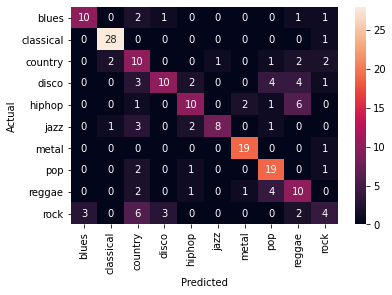

              precision    recall  f1-score   support

       blues       0.77      0.67      0.71        15
   classical       0.90      0.97      0.93        29
     country       0.34      0.56      0.43        18
       disco       0.71      0.42      0.53        24
      hiphop       0.62      0.50      0.56        20
        jazz       0.89      0.53      0.67        15
       metal       0.86      0.95      0.90        20
         pop       0.63      0.83      0.72        23
      reggae       0.40      0.56      0.47        18
        rock       0.36      0.22      0.28        18

    accuracy                           0.64       200
   macro avg       0.65      0.62      0.62       200
weighted avg       0.66      0.64      0.64       200

Accuracy for blues is: 0.7692307692307693 

Accuracy for classical is: 0.9032258064516129 

Accuracy for country is: 0.3448275862068966 

Accuracy for disco is: 0.7142857142857143 

Accuracy for hiphop is: 0.625 

Accuracy for jazz is: 0.888

In [0]:
test_accuracy_hist = np.arange(epoch).astype(dtype='float')
pred, target, test_loss_hist, test_accuracy_hist = test(test_batch_size)
report_performance(pred, target)

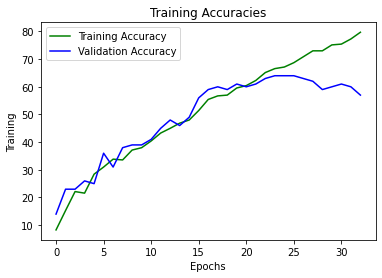

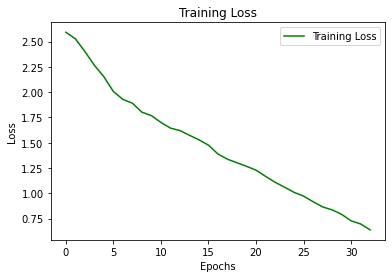

The End


In [0]:
#%%
plt.plot( train_accuracy_hist[:count], 'g', label='Training Accuracy')
plt.plot(validation_accuracy_hist[:count], 'b', label='Validation Accuracy')
plt.title('Training Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.legend()
plt.show()  



plt.plot(train_loss_hist[:count], 'g', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  


print("The End")